<a href="https://colab.research.google.com/github/kaicong12/CRNN-HandWriting-Recognition/blob/main/KC_Handwritting_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir -p words xml HTR_Using_CRNN/Model

In [3]:
!tar -xzf  "/content/gdrive/MyDrive/Colab Notebooks/words.tgz" -C "/content/words/"
!tar -xzf  "/content/gdrive/MyDrive/Colab Notebooks/xml.tgz" -C "/content/xml/"

# Data Preprocessing

In [4]:
import numpy as np
import cv2
import os
import os.path as osp
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.cElementTree as et

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3952819557885756233
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6245829480633354772
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
# This step is to check GPU is available or not.

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

1. Input shape for our architecture having an input image of height 32 and width 128. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the number of filters is increased from 64 to 512 layer by layer. 

2. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts. 

3. Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process. 

4. Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer. Then used two Bidirectional LSTM layers each of which has 128 units. 

5. This RNN layer gives the output of size (batch_size, 31, 63). Where 63 is the total number of output classes including blank character.

# Loss Function
Here, we are using the CTC loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC.

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing we will use the model that we have created earlier “act_model”. Let’s see the code:

# Train the Model
To train the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model on the basis of validation loss. In model.compile(), you can see that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier. labels as input to the model earlier.

Now train your model on 7850 training images and 876 validation images.

# Test the Model
Our model is now trained with 7850 images. Now its time to test the model. We can not use our training model because it also requires labels as input and at test time we can not have labels. So to test the model we will use ” act_model ” that we have created earlier which takes only one input: test images.

As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we used the CTC decoder to get the output text. Let’s see the code:

We use Jaro Distance & Ratio method to test accuracy.

# Create custom Training Pipeline to train with different data size

In [9]:
class HandwritingDataset:
  def __init__(self, xml_dir, png_dir):
    """
      Args:
        xml_dir (string): path to the folder which stores the xml file (e.g. /content/xml) 
        word_dir (string): path to the folder which stores the png images of the dataset (e.g. /content/words)
    """

    self.xml_dir = xml_dir
    self.png_dir = png_dir
    self.max_label_len = 0
    self.char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

  def extract_words_from_directories(self):
    words = []
    xml_files = os.listdir(self.xml_dir)

    for xml_filename in xml_files:
      tree=et.parse(osp.join(self.xml_dir, xml_filename))
      root=tree.getroot()

      for word in root.iter('word'):
        text_id = word.attrib['id']

        splits = text_id.split("-")
        split_0 = splits[0]
        split_1 = "-".join(splits[:2])
        split_2 = "-".join(splits[2:])

        filepath = osp.join(self.png_dir, split_0, split_1, f"{text_id}.png")

        # filepath = f"/content/words/{split_0}/{split_1}/{text_id}.png"
        if not osp.isfile(filepath):
          raise Exception(f"{filepath} not found.")

        words.append({
            'id': text_id,
            'image_filepath': filepath,
            'text': word.attrib['text']
        })
    
    return words

  def encode_to_labels(self, txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(self.char_list.index(chara))
        
    return dig_lst

  def process_image(self, img):
      """
      Converts image to shape (32, 128, 1) & normalize
      """
      w, h = img.shape
      
      # image thresholding
  #     _, img = cv2.threshold(img, 
  #                            128, 
  #                            255, 
  #                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      
      # Aspect Ratio Calculation
      new_w = 32
      new_h = int(h * (new_w / w))
      img = cv2.resize(img, (new_h, new_w))
      w, h = img.shape
      
      img = img.astype('float32')
      
      # Converts each to (32, 128, 1)
      if w < 32:
          add_zeros = np.full((32-w, h), 255)
          img = np.concatenate((img, add_zeros))
          w, h = img.shape
      
      if h < 128:
          add_zeros = np.full((w, 128-h), 255)
          img = np.concatenate((img, add_zeros), axis=1)
          w, h = img.shape
          
      if h > 128 or w > 32:
          dim = (128,32)
          img = cv2.resize(img, dim)
      
      img = cv2.subtract(255, img)
      
      img = np.expand_dims(img, axis=2)
      
      # Normalize 
      img = img / 255
      
      return img

  def train_valid_split(self):
      train_images = []
      train_labels = []
      train_input_length = []
      train_label_length = []
      train_original_text = []

      valid_images = []
      valid_labels = []
      valid_input_length = []
      valid_label_length = []
      valid_original_text = []

      words = self.extract_words_from_directories()
      for index, word in enumerate(words):
        image_filepath = word['image_filepath']
        text = word['text']

        # processing on image
        img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = self.process_image(img)
        except:
            continue

        # processing on label
        try:
            label = self.encode_to_labels(text)
        except:
            continue
        
        # added this line to prevent error from CTC computation
        if len(label) > 31:
          continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(text))
            valid_original_text.append(text)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(text))
            train_original_text.append(text)
        
        if len(text) > self.max_label_len:
            self.max_label_len = len(text)
    
      train_padded_labels = pad_sequences(train_labels, 
                            maxlen=self.max_label_len, 
                            padding='post',
                            value=len(self.char_list))

      valid_padded_labels = pad_sequences(valid_labels, 
                            maxlen=self.max_label_len, 
                            padding='post',
                            value=len(self.char_list))

      # Convert to numpy array.
      train_images = np.asarray(train_images)
      train_input_length = np.asarray(train_input_length)
      train_label_length = np.asarray(train_label_length)

      valid_images = np.asarray(valid_images)
      valid_input_length = np.asarray(valid_input_length)
      valid_label_length = np.asarray(valid_label_length)

      train_data = {
          "train_images": train_images,
          "train_padded_labels": train_padded_labels,
          "train_input_length": train_input_length,
          "train_label_length": train_label_length,
          "train_original_text": train_original_text
      }

      valid_data = {
          "valid_images": valid_images,
          "valid_padded_labels": valid_padded_labels,
          "valid_input_length": valid_input_length,
          "valid_label_length": valid_label_length,
          "valid_original_text": valid_original_text
      }

      return train_data, valid_data

In [10]:
class CRNN:
  def __init__(self, max_label_len, char_list):
    self.max_label_len = max_label_len
    # input with shape of height=32 and width=128, #RGB would have a depth of 3, Grey scale would only have a depth of 1
    self.inputs = Input(shape=(32,128,1))
    
    # convolution layer with kernel size (3,3)
    self.conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(self.inputs)
    # poolig layer with kernel size (2,2)
    self.pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(self.conv_1)
    
    self.conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(self.pool_1)
    self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(self.conv_2)
    
    self.conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(self.pool_2)
    
    self.conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(self.conv_3)

    # poolig layer with kernel size (2,1)
    self.pool_4 = MaxPool2D(pool_size=(2, 1))(self.conv_4)
    
    self.conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(self.pool_4)

    # Batch normalization layer
    self.batch_norm_5 = BatchNormalization()(self.conv_5)
    
    self.conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(self.batch_norm_5)
    self.batch_norm_6 = BatchNormalization()(self.conv_6)
    self.pool_6 = MaxPool2D(pool_size=(2, 1))(self.batch_norm_6)
    
    self.conv_7 = Conv2D(512, (2,2), activation = 'relu')(self.pool_6)
    
    self.squeezed = Lambda(lambda x: K.squeeze(x, 1))(self.conv_7)
    
    # bidirectional LSTM layers with units=128
    self.blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(self.squeezed)
    self.blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(self.blstm_1)
    
    self.outputs = Dense(len(char_list)+1, activation = 'softmax')(self.blstm_2)
  
  def build_valid_model(self, weight_path):
    # model to be used at test time
    # share the same architecture as train_model
    act_model = Model(self.inputs, self.outputs)
    act_model.load_weights(weight_path)

    return act_model

  def ctc_lambda_func(self, args):
        y_pred, labels, input_length, label_length = args

        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

  def build_train_model(self):
    # loss function
    the_labels = Input(name='the_labels', shape=[self.max_label_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(self.ctc_lambda_func, output_shape=(1,), name='ctc')([self.outputs, the_labels, input_length, label_length])

    #model to be used at training time
    model = Model(inputs=[self.inputs, the_labels, input_length, label_length], outputs=loss_out)

    return model    

In [11]:
class Pipeline:
  def __init__(self, dataset_obj, train_data, valid_data, model, sample_size, batch_size, epochs, optimizer_name):
    """
      Args:
        dataset: Dataset objects which contains the training and validation data
        sample_size: sample size to be used for the experiment, ignore the rest of the dataset
    """
    self.model = model
    self.dataset_obj = dataset_obj
    self.sample_size = sample_size
    self.batch_size = batch_size
    self.epochs = epochs
    self.optimizer_name = optimizer_name
    self.history = None

    # training and validation set to be used for this pipeline
    self.train_images = train_data["train_images"][:self.sample_size]
    self.train_padded_labels = train_data["train_padded_labels"][:self.sample_size]
    self.train_input_length = train_data["train_input_length"][:self.sample_size]
    self.train_label_length = train_data["train_label_length"][:self.sample_size]
    self.train_original_text = train_data["train_original_text"][:self.sample_size]

    self.valid_images = valid_data["valid_images"][:self.sample_size]
    self.valid_padded_labels = valid_data["valid_padded_labels"][:self.sample_size]
    self.valid_input_length = valid_data["valid_input_length"][:self.sample_size]
    self.valid_label_length = valid_data["valid_label_length"][:self.sample_size]
    self.valid_original_text = valid_data["valid_original_text"][:self.sample_size]

  def train(self, early_stopping=False):
    """
    Return:
      best_weight_path (string): path to best training weights
      history (obj): history object of the model training
    """
    # build new training model
    ocr_model = self.model.build_train_model()

    # model compilation
    ocr_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = self.optimizer_name, metrics=['accuracy'])
    now = datetime.now()
    date_time = now.strftime("%m_%d_%Y_%H%M%S")

    filepath=f"HTR_Using_CRNN/Model/{date_time}.hdf5"

    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    if early_stopping:
      earlystopping = EarlyStopping(monitor='val_loss', patience=10)
      callbacks_list.append(earlystopping)

    # training starts here
    history = ocr_model.fit(x=[self.train_images, self.train_padded_labels, self.train_input_length, self.train_label_length],
                    y=np.zeros(len(self.train_images)),
                    batch_size=self.batch_size, 
                    epochs=self.epochs, 
                    validation_data=([self.valid_images, self.valid_padded_labels, self.valid_input_length, self.valid_label_length], [np.zeros(len(self.valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

    return filepath, history

  def visualize_prediction(self, weight_path, start_idx, end_idx):
    """
    Plot prediction of images from start_idx: end_idx
    """
    # load the saved best model weights
    valid_model = self.model.build_valid_model(weight_path)

    # predict outputs on validation images
    prediction = valid_model.predict(self.valid_images[start_idx: end_idx])
    
    # use CTC decoder
    decoded = K.ctc_decode(prediction,   
                          input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                          greedy=True)[0][0]

    out = K.get_value(decoded)

    # see the results
    for i, x in enumerate(out):
        print("original_text = ", self.valid_original_text[start_idx+i])
        print("predicted text = ", end = '')
        for p in x:
            if int(p) != -1:
                print(self.dataset_obj.char_list[int(p)], end = '')
        plt.imshow(self.valid_images[start_idx+i].reshape(32,128), cmap=plt.cm.gray)
        plt.show()
        print('\n')

In [12]:
# utils function block

def plot_graph(epochs, acc, val_acc, title):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [13]:
dataset = HandwritingDataset("/content/xml", "/content/words")
train_data, valid_data = dataset.train_valid_split()

In [14]:
sample_sizes = [10000, 50000, 100000]
batch_size = 8
epochs = 30
optimizer_name = 'sgd'

histories = {}
pipelines = {}
best_weights = {}
for sample_size in sample_sizes:
  model = CRNN(dataset.max_label_len, dataset.char_list)
  pipeline = Pipeline(dataset, train_data, valid_data, model, sample_size, batch_size, epochs, optimizer_name)
  best_weight, history = pipeline.train(early_stopping=True)

  # store training history for this sample size
  histories[sample_size] = history
  pipelines[sample_size] = pipeline
  best_weights[sample_size] = best_weight

Epoch 1/30

Epoch 1: val_loss improved from inf to 12.40792, saving model to HTR_Using_CRNN/Model/10_25_2022_072631.hdf5
1250/1250 - 60s - loss: 13.8289 - accuracy: 3.0000e-04 - val_loss: 12.4079 - val_accuracy: 0.0416 - 60s/epoch - 48ms/step
Epoch 2/30

Epoch 2: val_loss improved from 12.40792 to 10.33899, saving model to HTR_Using_CRNN/Model/10_25_2022_072631.hdf5
1250/1250 - 44s - loss: 11.3619 - accuracy: 0.0287 - val_loss: 10.3390 - val_accuracy: 0.0839 - 44s/epoch - 35ms/step
Epoch 3/30

Epoch 3: val_loss improved from 10.33899 to 9.20492, saving model to HTR_Using_CRNN/Model/10_25_2022_072631.hdf5
1250/1250 - 42s - loss: 9.7549 - accuracy: 0.0665 - val_loss: 9.2049 - val_accuracy: 0.0998 - 42s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss improved from 9.20492 to 7.66899, saving model to HTR_Using_CRNN/Model/10_25_2022_072631.hdf5
1250/1250 - 42s - loss: 8.1450 - accuracy: 0.1097 - val_loss: 7.6690 - val_accuracy: 0.1593 - 42s/epoch - 34ms/step
Epoch 5/30

Epoch 5: val_loss im

In [15]:
# pipeline.visualize_prediction(best_weight, 102, 105)

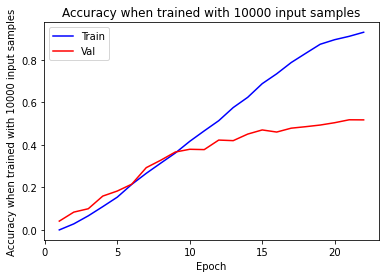

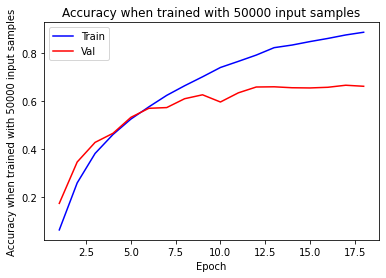

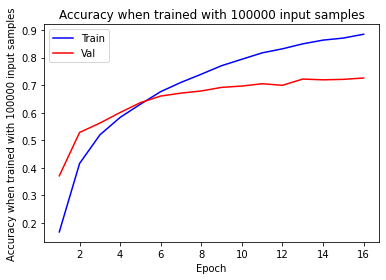

In [18]:
for sample_size, history in histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1,len(acc)+1)

    # utils function to visualize training and validation accuracy
    plot_graph(epochs, acc, val_acc, f"Accuracy when trained with {sample_size} input samples")

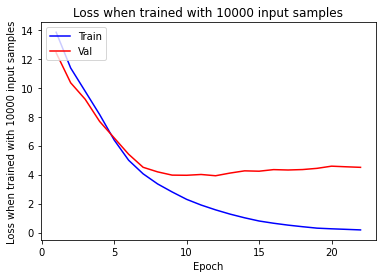

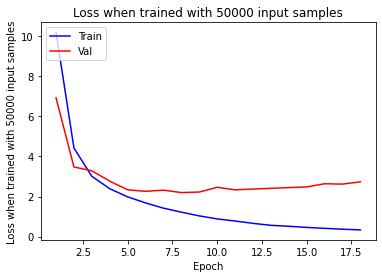

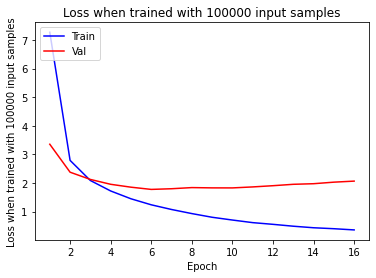

In [19]:
for sample_size, history in histories.items():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    # utils function to visualize training and validation accuracy
    plot_graph(epochs, loss, val_loss, f"Loss when trained with {sample_size} input samples")